In [3]:
%matplotlib inline

In [4]:
import matplotlib.pylab as plt
import numpy as np

In [5]:
ncol = 94
nrow = 63
# number of boundary cells


In [6]:
def input():
    if True:
        global grav, dt, tmax, xsplit, xn, epsh, beta, xk
        global ainflt, binflt,tc, cappa, istart, imass, ifront, nprt, nbcell
        global ncol, nrow, nmon, xmon, ymon
        global inum, ipos, itype, ilim
        global kbeg, kend, h0l, u0l, v0l, h0r, u0r, v0r
        global fix, isurf, t
        global h, hp, u, up, v, vp, t0, q, tclip
        global dh, du, dv
        global f, qsource
        global zslope, itest
        grav  = 9.806   
        dt =  0.15  
        tmax =  2000.
        xsplit = 100.  #  dividing line for dam break problem
        xn = 0.05      # Manning n  
        epsh = 0.0025  #  depth tolerence for dry bed problems.
        beta =  2.0    # 
        xk  =  3.9217e-4  #  m/s^a where a 0.5
        ainflt =      0.5  
        binflt =     2.65e-7
        tc = 6840.
        cappa = 0.99
        istart = 0   # If imass or ifront = 1, open a file 'diag.out'
        imass  = 0  
        ifront  = 0 
        nprt = 10     # print frequency
        nbcell = 386  # number of boundary cells
    
    i = 0;  dryin = []
    for line in open("dryin.dat", 'r'):
        i += 1
        dryin.append(line)
    
    nrow = []
    ncol = []
    for line in range(11, 11+386):
        #print dryin[line]
        a = dryin[line].strip().split(" ")
        a = [int(x) for x in a if x]
        ncol.append(a[0])
        nrow.append(a[1])
    nrow = len(np.unique(nrow))
    ncol = len(np.unique(ncol))
    
    inum = np.zeros([ncol+1,nrow+1], dtype = int)
    itype = np.zeros([ncol+1, nrow+1, 2])    
    ipos = np.zeros([ncol+1, nrow+1, 2]) 

    for line in range(11, 11+386):
        a = dryin[line].strip().split(" ")
        a = [int(x) for x in a if x]
        j = a[0] 
        k = a[1] 
        inum[j, k] = a[2]
        itype[j,k,0]= a[3]
        if a[2] == 1:
            ipos[j, k,0] = a[4]
        elif a[2] > 1:
            itype[j,k,1]= a[4]
            ipos[j,k,0]= a[5]
            ipos[j,k,1] = a[6]  
    kbeg = [0]
    kend = [0]
    for line in range(400, 399+ncol):
        a = dryin[line].strip().split(" ")
        a = [int(x) for x in a if x]
        kbeg.append(a[1])
        kend.append(a[2])

    kbeg.append(kbeg[-1])
    kend.append(kend[-1])  

    h0l = 0.; u0l = 0.; v0l = 0.
    h0r = 0.; u0r = 0.; v0r = 0.
    
    ndir = 3  # number of fixed bc cells    
    fix = np.zeros([ncol+1, nrow+1, 3])
    for i, line in enumerate(range(501, 501+ ndir)):
        a = dryin[line].strip().split(" ")
        a = [float(x.strip().replace("d", "")) for x in a if x]
        j = int(a[0])
        k = int(a[1])
    
        fix[j, k, 0] = a[2]
        fix[j, k, 1] = a[3]    
        fix[j, k, 2] = a[4]    
    nmon = 3  # number of monitoring points
    #period = 1.
    xmon = np.zeros(nmon)
    ymon = np.zeros(nmon)
    for i, line in enumerate(range(507, 507+ nmon)):
        a = dryin[line].strip().split(" ")
        a = [float(x.strip().replace("d", "")) for x in a if x]
        i = int(a[0]- 1)
        xmon[i] = a[1]
        ymon[i] = a[2]
        
    ## user input
    #isurf = 1 # 'enter a 1 to set free surface elevation'
    isurf = 2 # 'enter a 2 to set flow depth'
    ilim = 5
    sw = 0.
    if ilim ==0: sw = 1.0
    if istart == 1:  # incomplete code here
         t = float(raw_input("enter restart time: "))
    grid()
    
    h = np.zeros([ncol+2, nrow+2]) 
    hp = np.zeros([ncol+2, nrow+2])
    u = np.zeros([ncol+2, nrow+2])
    up = np.zeros([ncol+2, nrow+2])
    v = np.zeros([ncol+2, nrow+2])
    vp = np.zeros([ncol+2, nrow+2])
    t0 = np.zeros([ncol+2, nrow+2])
    q  = np.zeros([ncol+2, nrow+2, 3])
    tclip = 0.  ## tclip used to determine dt - timestep interval
    
    # modified by conds, predict, and fluxes functions
    dh = np.zeros([ncol+2, nrow+2,2])  
    du = np.zeros([ncol+2, nrow+2,2])  
    dv = np.zeros([ncol+2, nrow+2,2])  
    f = np.zeros([ncol+2, nrow+2,3,2])
    qsource = np.zeros([ncol+2, nrow+2,3,2])
    if istart != 1: 
        t = 0.   #  set the initial time variable
        # dt = tmax/dfloat(nt)
        for j in range(1,ncol+1):
            for k in range(kbeg[j], kend[j]+1):
                if xc[j,k] < xsplit:
                    if isurf == 1:   # if isurf = 1,  subtract z from h0l and h0r to get h
                        h[j,k] = h0l - zc[j,k]
                    else:     #
                        h[j,k] = h0l
                    u[j,k] = u0l
                    v[j,k] = v0l
                else:
                    if isurf == 1:  
                        h[j,k] = h0r - zc[j,k]
                    else:
                        h[j,k] = h0r

                    u[j,k] = u0r
                    v[j,k] = v0r

                if xk > 0. and h[j,k] == 0.:  ## set t0 to t in all the cells where h[j,k] = 0
                    t0[j,k] = t     
                    
    for j in range(1, ncol+1):
        for k in range(kbeg[j] , kend[j]+1):
            if h[j,k] < 0.0:   # correct depth < 0
                h[j,k] = 0.
            q[j,k,0] = h[j,k]
            q[j,k,1] = h[j,k]*u[j,k]
            q[j,k,2] = h[j,k]*v[j,k]

            for i in range(inum[j, k]):
                # If solitary wave profile is subcritical and h > 0
                if (itype[j,k,i] ==  5) & (fix[j,k,0] != 0.): 
                        if isurf == 1:    # 1 = set free surface elevation
                            hdum = fix[j,k,0] - zc[j,k]
                        else:
                            hdum = fix[j,k,0]
                        if (hdum <= 0.0):
                            print 'ERROR: depth specification for solitary \
                                wave \n BC is invalid'
                #  For fixed flux BCs, must initialize depth.
                if (itype[j,k,i] == 4):   # Specified flow rate (subcritical).
                    print  'fixed flux BC is requested in cell ',j,k
                    jj, kk, j2, k2 = findbc(i,j,k)
                    if ipos[j,k,i] == 2 or ipos[j,k,i] ==  4:  # If vertical faces
                        qflux = fix[j,k,1]*cn[j,k,0] + fix[j,k,2]*sn[j,k,0]  #  
                        dx =   deta[j,k,1]*area[j,k]
                        dy = - deta[j,k,0]*area[j,k]
                        dss = np.sqrt(dx*dx + dy*dy)
                        if h[j,k] < epsh:
                            print '  bed adjacent to the boundary is dry'
                             # if qflux_x *dz/dx < 0 and manning N > 0
                            if (qflux*dz[j,k,0] < 0.) & (xn > 0.): 
                                qflux = np.abs(qflux)               
                                hnorm= (qflux*xn/ np.sqrt(np.abs(dz[j,k,0]/dss)))**(3./5.)
                                print '\t normal depth = ',hnorm,' is specified'
                                h[jj,kk] = hnorm
                                hp[jj,kk] = hnorm
                            else:
                                print '\t adverse slope or zero Manning n in cell'
                                print '\t enter initial flow depth at specified'
                                print '\t flux boundary ', j,k,ipos[j,k,i]
                                h[jj,kk] = float(raw_input(""))
                                hp[jj,kk] = h[jj,kk]
                        qflux = np.abs(qflux)
                        tclip1 = (xk*dss/(qflux*(1.0-cappa)))**(1.0/(1.0-ainflt))
                        if (tclip1 > tclip):
                            tclip = tclip1

                    # If horizontal 
                    elif ipos[j,k,i] == 1 or ipos[j,k,i] ==  3:  
                        qflux = fix[j,k,1]*cn[j,k,1] + fix[j,k,2]*sn[j,k,1]    
                        dx = - dxi[j,k,1]*area[j,k]
                        dy =  dxi[j,k,0]*area[j,k]
                        dss = np.sqrt(dx*dx + dy*dy)
                        if h[j,k] < epsh:
                            print  'bed adjacent to the boundary is dry'
                            if (qflux*dz[j,k,1] < 0.) and (xn > 0.0):
                                qflux = np.abs(qflux)
                                hnorm=(qflux*xn/np.sqrt(np.abs(dz[j,k,0]/dss)))**(3./5.)
                                print '\t normal depth =', hnorm,' is specified'
                                h[jj,kk] = hnorm
                                hp[jj,kk] = hnorm
                            else:
                                print '\t adverse slope or zero Manning n in cell'
                                print '\t enter initial flow depth at specified'
                                print '\t flux boundary =', j,k,ipos[j,k,i]
                                h[jj,kk] = 1# float(raw_input(""))
                                hp[jj,kk] = h[jj,kk]  # set hp outside boundary equal to h inside
                            qflux = np.abs(qflux)
                            tclip2 = (xk*dss/(qflux*(1.0-cappa)))**(1.0/(1.0-ainflt))
                            if (tclip2 > tclip):
                                tclip = tclip2
                #  For specified free surface BCs.
                if (itype[j,k,i] == 3) and (isurf == 1):
                        check = fix[j,k,0] - zc[j,k] - amp
                        if (check < 0.0): 
                            print  'WARNING: specified tidal amplitude will'
                            print  'result in negative specified depth'
                            print  'specified depth will be set to zero'
    if xk > 0.0:
        if(tclip > 0.0):
            zslope = xk*tclip**(ainflt - 1.0)
            print ' '
            #print '*************************************************'
            print 'Kostiakov infiltration formula modified'
            print 'fot time less than ', tclip
            print 'infiltration slope is ', zslope
            #print '*************************************************'
        else:
            tclip = 0.0
    itest = 0
  
    interp(h, u, v)
    
    for j in range(0,ncol+1):     # filling in the dam coordinates
        for k in range(0,nrow+1):
            if xc[j, k] == 0:
                xc[j, k] = np.mean([xc[j-1,k], xc[j+1,k]])
            if yc[j, k] == 0:
                yc[j, k] = np.mean([yc[j-1,k], yc[j+1,k]])
#             if zc[j, k] == 0:
#                 zc[j, k] = np.mean([zc[j-1,k], zc[j+1,k]])
                
#     file = open("diag_py.out", "w")
#     file.write('t\t vol \t xf  \n')
#     file.close
#     file = open("restart_py.out", "w")
#     file.close
#     file = open("dryout_py.dat", "w")
#     file.close
#     file = open("movie_py.dat", "w")
#     file.close

In [7]:
def grid():
    """
    Called from the input function only
    Read grid data from file 'coords'.
    """
    global npt, ne, x, y, z, nop
    global xc, yc, zc  #  coordinates of cell centers
    global dxi, deta, dz, area, sx, sy
    global ds, sn, cn  #
    i = 0
    coords = []
    for line in open("coords", 'r'):
        i += 1
        item = line.rstrip() # strip off newline and any other trailing whitespace
        coords.append(line)
    npt, ne = [int(j) for j in coords[0].split()]
    x = np.arange(float(npt+1))
    y = np.arange(float(npt+1))
    z = np.arange(float(npt+1))

    for i in range(1, npt+1):
        x[i], y[i], z[i] = [float(l) for l in coords[i].split()]
    
    nop = np.zeros([ncol+1,nrow+1, 4], dtype = int)
    count = 0
    for j in range(1, ncol+1):
        for k in range(kbeg[j], kend[j]+1):
            nop[j, k, :]  = [int(l) for l in coords[count+1+npt].split()]
            count += 1

    xc  = np.zeros([ncol+2, nrow+2])  #  
    yc  = np.zeros([ncol+2, nrow+2])
    zc  = np.zeros([ncol+2, nrow+2])
    
    dxi  = np.zeros([ncol+2, nrow+2, 2])
    deta  = np.zeros([ncol+2, nrow+2, 2])
    dz  = np.zeros([ncol+2, nrow+2, 2])

    area = np.zeros([ncol+2, nrow+2])
    sx = np.zeros([ncol+2, nrow+2])  # dz/dx
    sy = np.zeros([ncol+2, nrow+2])  # dz/sy
    
    
    ## Compute grid metrics
    for j in range(1, ncol+1):
        for k in range(kbeg[j], kend[j]+1):
            n1 = nop[j, k, 0] 
            n2 = nop[j, k, 1]       
            n3 = nop[j, k, 2]        
            n4 = nop[j, k, 3]  
            xc[j,k] = 0.25*(x[n1] + x[n2] + x[n3] + x[n4])  
            yc[j,k] = 0.25*(y[n1] + y[n2] + y[n3] + y[n4])
            zc[j,k] = 0.25*(z[n1] + z[n2] + z[n3] + z[n4])
            dxdxi = 0.5*(-x[n1] + x[n2] + x[n3] - x[n4])   # 1
            dxdeta = 0.5*(-x[n1] - x[n2] + x[n3] + x[n4])  # 0    
            dydxi = 0.5*(-y[n1] + y[n2] + y[n3] - y[n4])   # 0
            dydeta = 0.5*(-y[n1] - y[n2] + y[n3] + y[n4])  #       
            area[j,k] = dxdxi*dydeta - dxdeta*dydxi
            if area[j,k] < 0:
                print "error"    
            dxi[j,k,0] =  dydeta/area[j,k]
            deta[j,k,0] = -dydxi/area[j,k]
            dxi[j,k,1] =  -dxdeta/area[j,k]
            deta[j,k,1] = dxdxi/area[j,k] 
            sx[j,k] = ((z[n2]-z[n4])*(y[n3]-y[n1])-(z[n3]-z[n1])*(y[n2]-y[n4]))/(2.*area[j,k])
            sy[j,k] = ((z[n3]-z[n1])*(x[n2]-x[n4])-(z[n2]-z[n4])*(x[n3]-x[n1]))/(2.*area[j,k])  
            dz[j,k,0] = sx[j,k]*dxdxi  + sy[j,k]*dydxi
            dz[j,k,1] = sx[j,k]*dxdeta + sy[j,k]*dydeta 
    ## Compute cell face angles
    ds  = np.zeros([ncol+2, nrow+2, 2])
    sn  = np.zeros([ncol+2, nrow+2, 2])
    cn  = np.zeros([ncol+2, nrow+2, 2])
    for j in range(1, ncol+1):
        for k in range(kbeg[j] , kend[j]+1):
            n1 = nop[j, k, 0] 
            n2 = nop[j, k, 1]       
            n3 = nop[j, k, 2]        
            n4 = nop[j, k, 3] 
            # Horizontal face.
            ddx =  x[nop[j,k,1]] - x[nop[j,k,0]]   # x[n2] - x[n1]  = 1
            ddy =  y[nop[j,k,1]] - y[nop[j,k,0]]   # y[n2] - y[n1]  = 0
            ds[j,k,1] = np.sqrt(ddx*ddx + ddy*ddy)  # = 1 = area
            sn[j,k,1] = ddx/ds[j,k,1]  # 1  
            cn[j,k,1] = -ddy/ds[j,k,1] # 0    
            ## Vertical face
            ddx =  x[nop[j,k,3]]-x[nop[j,k,0]]    # x[n4] - x[n1] = 0
            ddy =  y[nop[j,k,3]] - y[nop[j,k,0]]  # y[n4] - y[n1]  = 1
            ds[j,k,0] = np.sqrt(ddx*ddx + ddy*ddy)  # = 1
            sn[j,k,0] = -ddx/ds[j,k,0]  # 0
            cn[j,k,0] =  ddy/ds[j,k,0]  # 1    
            for i in range(inum[j, k]):
                if ipos[j, k, i] == 3:  # Top (boundary) faces.
                    ddx = x[nop[j,k,2]] - x[nop[j,k,3]]
                    ddy = y[nop[j,k,2]] - y[nop[j,k,3]]
                    ds[j,k+1,1] = np.sqrt(ddx*ddx + ddy*ddy)
                    sn[j,k+1,1] = ddx/ds[j,k+1,1]   
                    cn[j,k+1,1] = -ddy/ds[j,k+1,1]
                elif ipos[j, k, i] == 2:   # Right (boundary) faces.
                    ddx = x[nop[j,k,2]] - x[nop[j,k,1]]
                    ddy = y[nop[j,k,2]] - y[nop[j,k,1]]
                    ds[j+1,k,0] = np.sqrt(ddx*ddx + ddy*ddy)
                    sn[j+1,k,0] = -ddx/ds[j+1,k,0]  
                    cn[j+1,k,0] = ddy/ds[j+1,k,0]
                    
    # Compute some things in ghost cells
    for j in range(1, ncol+1):
        for k in range(kbeg[j], kend[j]+1):
            for i in range(inum[j, k]):  # loop over cell faces
                ##  jj, kk is the cell immediately across the boundary face i
                ##  j2, k2 is the cell on the opposing size of j,k from jj,kk
                jj, kk, j2, k2 = findbc(i, j, k,)  
                if (jj < 0) or (kk < 0):
                    print jj, kk
                area[jj,kk] = area[j,k]
                sx[jj,kk] = sx[j,k]
                sy[jj,kk] = sy[j,k]
                dxi[jj,kk,0] = dxi[j,k,0]
                deta[jj,kk,0] = deta[j,k,0]
                dxi[jj,kk,1] = dxi[j,k,1]
                deta[jj,kk,1] = deta[j,k,1]
                xc[jj,kk] = 2.*xc[j,k] - xc[j2,k2]
                yc[jj,kk] = 2.*yc[j,k] - yc[j2,k2]
                zc[jj,kk] = 2.*zc[j,k] - zc[j2,k2]  


In [8]:
def findbc(i, j, k):
    """ findbc gets called from the grid function:
        :param i:  dummy index for the face number in ipos
        :param j:  dummy index for column number (eventually row)
        :param k:  dummy index for row number (eventually column)
        :return:   (jj,kk): the indices of the ghost cell 
                   (j2, k2):  indices of the cell opposite the ghost cell
        """
    if ipos[j, k, i] == 1:
        jj = j
        kk = k-1
        j2 = j 
        k2 = k+1
    if ipos[j, k, i] == 2:
        jj = j+1
        kk = k
        j2 = j-1
        k2 = k
    if ipos[j, k, i] == 3:
        jj = j
        kk = k+1
        j2 = j
        k2 = k-1
    if ipos[j, k, i] == 4:
        jj = j-1
        kk = k
        j2 = j+1
        k2 = k        
    return  jj, kk, j2, k2


In [9]:
def interp(h, u,v):
    for j in range(1,ncol+1):
        for k in range(kbeg[j], kend[j]+1):
            # Extrapolate to corner cells
            ibc1 = 0
            ibc2 = 0
            ibc3 = 0
            ibc4 = 0
            for i in range(inum[j,k]):
                if (ipos[j,k,i] == 1): ibc1 = 1 
                if (ipos[j,k,i] == 2): ibc2 = 1
                if (ipos[j,k,i] == 3): ibc3 = 1
                if (ipos[j,k,i] == 4): ibc4 = 1
            if (ibc1 == 1 and ibc4 == 1):
                xc[j-1,k-1] = 2.*xc[j,k] - xc[j+1,k+1]
                yc[j-1,k-1] = 2.*yc[j,k] - yc[j+1,k+1]
                zc[j-1,k-1] = 2.*zc[j,k] - zc[j+1,k+1]
                h[j-1,k-1] = 2.*h[j,k] - h[j+1,k+1]
                u[j-1,k-1] = 2.*u[j,k] - u[j+1,k+1]
                v[j-1,k-1] = 2.*v[j,k] - v[j+1,k+1] 
            elif (ibc1 == 1 and ibc2 == 1):
                xc[j+1,k-1] = 2.*xc[j,k] - xc[j-1,k+1]
                yc[j+1,k-1] = 2.*yc[j,k] - yc[j-1,k+1]
                zc[j+1,k-1] = 2.*zc[j,k] - zc[j-1,k+1]
                h[j+1,k-1] = 2.*h[j,k] - h[j-1,k+1]
                u[j+1,k-1] = 2.*u[j,k] - u[j-1,k+1]
                v[j+1,k-1] = 2.*v[j,k] - v[j-1,k+1]    
            elif (ibc2 == 1 and ibc3 == 1):
                xc[j+1,k+1] = 2.*xc[j,k] - xc[j-1,k-1]
                yc[j+1,k+1] = 2.*yc[j,k] - yc[j-1,k-1]
                zc[j+1,k+1] = 2.*zc[j,k] - zc[j-1,k-1]
                h[j+1,k+1] = 2.*h[j,k] - h[j-1,k-1]
                u[j+1,k+1] = 2.*u[j,k] - u[j-1,k-1]
                v[j+1,k+1] = 2.*v[j,k] - v[j-1,k-1]
            elif (ibc3 == 1 and ibc4 == 1):
                xc[j-1,k+1] = 2.*xc[j,k] - xc[j+1,k-1]
                yc[j-1,k+1] = 2.*yc[j,k] - yc[j+1,k-1]
                zc[j-1,k+1] = 2.*zc[j,k] - zc[j+1,k-1]
                h[j-1,k+1]  = 2.*h[j,k] - h[j+1,k-1]
                u[j-1,k+1]  = 2.*u[j,k] - u[j+1,k-1]
                v[j-1,k+1]  = 2.*v[j,k] - v[j+1,k-1]
            h, u, v = bconds(j,k,inum, h,u,v, dh, du, dv)
        

In [10]:
def bconds(j, k, inum,  hdum, udum, vdum, dh, du, dv):
    for i in range(inum[j, k]):
        if(ipos[j,k,i] == 1):   # front face
            jj = j
            kk = k-1
            jl = j
            kl = k 
            j2 = j
            k2 = k+1
            io = 1 
        elif(ipos[j,k,i] == 2): # right face
            jj = j+1
            kk = k 
            jl = j+1 
            kl = k  
            j2 = j-1
            k2 = k
            io = 0
        elif(ipos[j,k,i] == 3):  # back face
            jj = j
            kk = k+1
            jl = j
            kl = k+1
            j2 = j
            k2 = k-1
            io = 1 
        elif(ipos[j,k,i] == 4):  # left face
            jj = j-1
            kk = k 
            jl = j
            kl = k 
            j2 = j+1
            k2 = k  
            io = 0  
        t0[jj,kk] = t0[j,k]
        if(itype[j,k,i] == 0):  ##  This is an open boundary
            dh[jj,kk,io] = dh[j,k,io]
            du[jj,kk,io] = du[j,k,io]
            dv[jj,kk,io] = dv[j,k,io]                               
            hdum[jj,kk] = 2.0*hdum[j,k] - hdum[j2,k2]
            udum[jj,kk] = 2.0*udum[j,k] - udum[j2,k2]
            vdum[jj,kk] = 2.0*vdum[j,k] - vdum[j2,k2]
    
        elif(itype[j,k,i] == 1): ## Wall boundary
            dh[jj,kk,io] = dh[j,k,io] 
            du[jj,kk,io] = du[j,k,io]
            dv[jj,kk,io] = dv[j,k,io]                          
            hdum[jj,kk] = 2.0*hdum[j,k] - hdum[j2,k2]
            udum[jj,kk] = udum[j,k]*(sn[jl,kl,io]*sn[jl,kl,io] - \
                                     cn[jl,kl,io]*cn[jl,kl,io]) - \
                                    2.0*vdum[j,k]*sn[jl,kl,io]*cn[jl,kl,io]
            vdum[jj,kk] = vdum[j,k]*(cn[jl,kl,io]*cn[jl,kl,io] - \
                            sn[jl,kl,io]*sn[jl,kl,io]) - \
                            2.0*udum[j,k]*sn[jl,kl,io]*cn[jl,kl,io]
                
        elif itype[j,k,i] == 2:  # Specified depth and velocity (supercritical)
            dh[jj,kk,io] = 0.0
            du[jj,kk,io] = 0.0
            dv[jj,kk,io] = 0.0                 
            hdum[jj,kk] = fix[j,k,0]
            udum[jj,kk] = fix[j,k,1]
            vdum[jj,kk] = fix[j,k,2]
            if isurf == 1:
                hdum[jj,kk] = hdum[jj,kk] - zc[j,k]
                
        elif itype[j,k,i] == 3: #Tidal (subcritical)
            dh[jj,kk,io] = 0.0
            du[jj,kk,io] = 0.0
            dv[jj,kk,io] = 0.0                               
            hdum[jj,kk] = fix[j,k,0] + amp*dcos(-6.283185*t/period)
            udum[jj,kk] = udum[j,k]
            vdum[jj,kk] = vdum[j,k] 
            if(isurf == 1):
                hdum[jj,kk] = hdum[jj,kk] - zc[j,k]

        elif itype[j,k,i] == 4:  # Specified flow rate (subcritical)
            du[jj,kk,io] =  0.0
            dv[jj,kk,io] =  0.0 
            if hdum[j,k] > epsh:
                hdum[jj,kk] = hdum[j,k]
                dh[jj,kk,io] =  0.0
            elif hdum[j,k]*hdum[j2,k2] > epsh:
                hdum[jj,kk] = 2.0*hdum[j,k] - hdum[j2,k2]
                dh[jj,kk,io] = dh[j,k,io]

            if hdum[jj,kk] > epsh:
                udum[jj,kk] = fix[j,k,1]/hdum[jj,kk]
                vdum[jj,kk] = fix[j,k,2]/hdum[jj,kk]
            else:
                udum[jj,kk] = 0.0
                vdum[jj,kk] = 0.0   
                
        elif itype(j,k,i) == 5: # Solitary wave profile (subcritical).
            dh[jj,kk,io] = 0.0
            du[jj,kk,io] = 0.0
            dv[jj,kk,io] = 0.0 
            dum = period - t
            if(dum < -36.0): 
                dum = -36.0
            hdum[jj,kk] = fix[j,k,1] + 2.0*amp/(np.cosh(dum)*np.cosh(dum))
            udum[jj,kk] = u[j,k]
            vdum[jj,kk] = v[j,k] 
            if isurf ==1:
                hdum[jj,kk] = hdum[jj,kk] - zc[j,k]
            if hdum[jj,kk] < 0.0:
                hdum[jj,kk] = 0.0
            if hdum[jj,kk] < epsh:
                udum[jj,kk] = 0.0
                vdum[jj,kk] = 0.0
    return hdum, udum, vdum

In [11]:
input()

fixed flux BC is requested in cell  43 63
bed adjacent to the boundary is dry
	 adverse slope or zero Manning n in cell
	 enter initial flow depth at specified
	 flux boundary = 43 63 3.0
fixed flux BC is requested in cell  44 63
bed adjacent to the boundary is dry
	 adverse slope or zero Manning n in cell
	 enter initial flow depth at specified
	 flux boundary = 44 63 3.0
fixed flux BC is requested in cell  45 63
bed adjacent to the boundary is dry
	 adverse slope or zero Manning n in cell
	 enter initial flow depth at specified
	 flux boundary = 45 63 3.0
 
Kostiakov infiltration formula modified
fot time less than  2.31065668419
infiltration slope is  0.000257992247946


In [12]:
for j in range(0,ncol+1):     # filling in the dam coordinates
    for k in range(0,nrow+1):
        if xc[j, k] == 0:
            xc[j, k] = np.mean([xc[j-1,k], xc[j+1,k]])
        if yc[j, k] == 0:
            yc[j, k] = np.mean([yc[j-1,k], yc[j+1,k]])
        if zc[j, k] == 0:
            zc[j, k] = np.mean([zc[j-1,k], zc[j+1,k]])


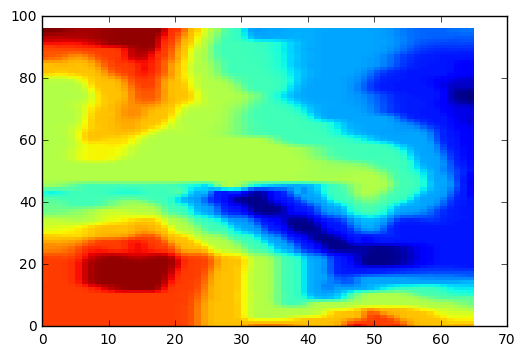

In [13]:
plt.pcolor(zc)

In [14]:
# f = open("mycoords_py.out", 'w')
# for j in range(ncol+2):
#     for k in range(nrow+2):
#         f.write("{0} {1} {2} {3} {4}\n".format(j, k, xc[j,k], yc[j,k], zc[j,k] ) )
# f.close()

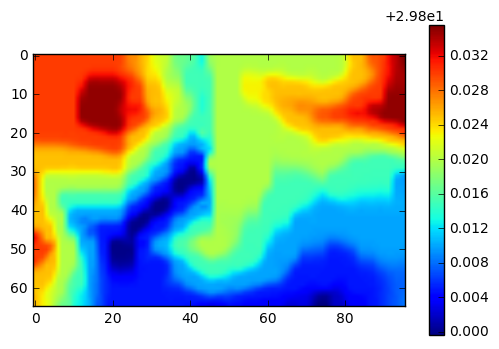

In [15]:
plt.imshow(zc.T)
plt.colorbar()

In [16]:
def transform():
    global j1, k1, w1, w2, w3, w4
    j1 = np.zeros(npt+1, dtype = int)
    k1 = np.zeros(npt+1, dtype = int)
    w1 = np.zeros(npt+1, dtype = float)
    w2 = np.zeros(npt+1, dtype = float)
    w3 = np.zeros(npt+1, dtype = float)
    w4 = np.zeros(npt+1, dtype = float)
    # bracket sampling location  
    for i in  range(1, 10+1):
        xdum = x[i] 
        ydum = y[i]     
        for j in range(1, ncol+1):
            for k in range(kbeg[j],kend[j]+2):
                if (xdum >= xc[j-1,k] and xdum < xc[j,k]):
                    if (ydum >= yc[j,k-1] and ydum < yc[j,k]):
                        j1[i] = j
                        k1[i] = k
                        lb = xc[j-1,k]; ub =xc[j,k]
                        break
                elif (xdum >= xc[j,k]) and (xdum <= xc[j+1,k]):
                    if (ydum >= yc[j,k-1] and ydum <= yc[j,k]):
                        j1[i] = j+1
                        k1[i] = k 
                        lb = xc[j,k]; ub =  xc[j+1,k]
                        break                        
        if (j1[i] == 0) or (k1[i] == 0):
            print 'error', xdum, ydum
        # Compute interpolation distances.      
        d1 = np.sqrt((xdum - xc[j1[i],k1[i]])**2 + (ydum - yc[j1[i],k1[i]])**2)
        d2 = np.sqrt((xdum - xc[j1[i]-1,k1[i]])**2 + (ydum - yc[j1[i]-1,k1[i]])**2)
        d3 = np.sqrt((xdum - xc[j1[i]-1,k1[i]-1])**2 + (ydum - yc[j1[i]-1,k1[i]-1])**2)
        d4 = np.sqrt((xdum - xc[j1[i],k1[i]-1])**2 + (ydum - yc[j1[i],k1[i]-1])**2)
        # Compute weights as distance inverses.
        # Tecplot states that the 3.5 exponent yields the smoothest results.
        if (d1 > 10) or (d2 > 10) or (d3 > 10) or (d4 > 10):
            print xdum, ydum
            #print j, k, "\t", lb, xdum, ub, "\t", ydum, yc[j1[i], k1[i]]# d1, d2, d3,d4
        if (d1 == 0.):
            w1[i] = 1.
            w2[i] = 0.
            w3[i] = 0.
            w4[i] = 0.
        elif (d2 == 0.):
            w1[i] = 0.
            w2[i] = 1.
            w3[i] = 0.
            w4[i] = 0.
        elif (d3 == 0.):
            w1[i] = 0.
            w2[i] = 0.
            w3[i] = 1.
            w4[i] = 0.  
        elif (d4 == 0.):
            w1[i] = 0.
            w2[i] = 0.
            w3[i] = 0.
            w4[i] = 1.          
        else:
            w1[i] = d1**(-3.5)  
            w2[i] = d2**(-3.5)
            w3[i] = d3**(-3.5)
            w4[i] = d4**(-3.5) 
        

In [17]:
def get_weights():
    global j1, k1, w1, w2, w3, w4, weights
    weights = [[0, 0, 0, 0, 0, 0, 0]]; 
    for line in open("weights_py.out", 'r'):
        weights.append([x for x in line.strip().split(", ")])
    weights = np.asarray(weights)
    j1 = weights[:, 1].astype(int)
    k1 = weights[:, 2].astype(int)
    w1 = weights[:, 3].astype(float)
    w2 = weights[:, 4].astype(float)
    w3 = weights[:, 5].astype(float)
    w4 = weights[:, 6].astype(float)

In [18]:
try:
    get_weights()
    print 'getting weights'
except IOError:
    transform()
# iprt = 0
# it = 0

getting weights


In [19]:
def array2col():
    global zn

    zn = np.zeros(npt+1)
    
    for i in  range(1, npt+1):
        # Interpolate data
        sumw = w1[i] + w2[i] + w3[i] + w4[i]  
        z[i] = (w1[i]*zc[j1[i],k1[i]] + w2[i]*zc[j1[i]-1,k1[i]] + 
                 w3[i]*zc[j1[i]-1,k1[i]-1] + w4[i]*zc[j1[i],k1[i]-1])/sumw
        

In [20]:
def movie():
    global hn, un, vn
    hn = np.zeros(npt+1)
    un = np.zeros(npt+1)
    vn = np.zeros(npt+1)
    
    for i in  range(1, npt+1):
        # Interpolate data
        sumw = w1[i] + w2[i] + w3[i] + w4[i]
        hn[i] = (w1[i]*h[j1[i],k1[i]] + w2[i]*h[j1[i]-1,k1[i]] + 
                w3[i]*h[j1[i]-1,k1[i]-1] + w4[i]*h[j1[i],k1[i]-1])/sumw
        un[i] = (w1[i]*u[j1[i],k1[i]] + w2[i]*u[j1[i]-1,k1[i]] + 
                w3[i]*u[j1[i]-1,k1[i]-1] + w4[i]*u[j1[i],k1[i]-1])/sumw
        vn[i] = (w1[i]*v[j1[i],k1[i]] + w2[i]*v[j1[i]-1,k1[i]] + 
                w3[i]*v[j1[i]-1,k1[i]-1] + w4[i]*v[j1[i],k1[i]-1])/sumw
        
        #z[i] = (w1[i]*zc[j1[i],k1[i]] + w2[i]*zc[j1[i]-1,k1[i]] + 
        #         w3[i]*zc[j1[i]-1,k1[i]-1] + w4[i]*zc[j1[i],k1[i]-1])/sumw
        

    if t ==0.:
        file = open("movie_py.dat", "w")
        file.write('VARIABLES = "X", "Y", "Z", "H", "D"\n')
        file.write('ZONE N=%i, E=%i, F=FEPOINT,  ET=QUADRILATERAL \n' %(npt, ne))
        for n in range(1,npt+1):
            file.write('%e %e %e %e %e \n' %(x[n],y[n],z[n],z[n],z[n]))
        for j in range(1, ncol+1):
            for k in range(kbeg[j],kend[j]+1):
                file.write('  '.join(['%i'%nop[j,k,i] for i in range(4)]))
                file.write('\n')
        file.close()
    elif np.mod(it,30)==0:
        file = open("movie_py.dat", "a")
        file.write('VARIABLES = "X", "Y", "Z", "H", "D"\n')
        file.write('ZONE N=   %i E=   %i F=FEPOINT,  ET=QUADRILATERAL  D=(FECONNECT,1,2,3)\n' %(npt, ne))
        for n in range(1,npt+1):
            file.write(''.join(['%f'%(hn[n]+z[n]),', %f'%hn[n]]))
            file.write('\n')
        file.close()

In [21]:
def predict(ilim, j, k, inum, h, u, v, dh, du, dv):
    if(ilim > 0):
        ## loop over coord. directons.  confusing variable use
        for kk in range(2):                  
            if(kk == 1):
                jr = j + 1
                jl = j - 1
                kr = k
                kl = k
            else:
                jr = j
                jl = j
                kr = k + 1
                kl = k - 1
            # Compute gradients only in wet cells.
            if(h[j,k] >= epsh): 
                # Limit free surface elevation to reduce dissipation..
                dh1 = h[j,k] + zc[j,k] - h[jl,kl] - zc[jl,kl]
                dh2 = h[jr,kr] + zc[jr,kr] - h[j,k] - zc[j,k]
                if(h[jl,kl] < epsh):
                    dh1 = 2.*dh1
                if(h[jr,kr] < epsh):
                    dh2 = 2.*dh2
                dhh = limitr(ilim,beta,dh1,dh2)
                dh[j,k,kk] = dhh - dz[j,k,kk]	
                # U velocity.            
                du1 = u[j,k] - u[jl,kl]
                du2 = u[jr,kr] - u[j,k]
                duu = limitr(ilim,beta,du1,du2)
                du[j,k,kk] = duu    
                # V velocity.
                dv1 = v[j,k] - v[jl,kl]
                dv2 = v[jr,kr] - v[j,k]
                dvv = limitr(ilim,beta,dv1,dv2)
                dv[j,k,kk] = dvv 
            else:
                dh[j,k,kk] = 0.
                du[j,k,kk] = 0.
                dv[j,k,kk] = 0.
            # Generalized velocities.
            uxi = u[j,k]*dxi[j,k,0] + v[j,k]*dxi[j,k,1]
            ueta = u[j,k]*deta[j,k,0] + v[j,k]*deta[j,k,1]            
            qs = source(j, k, h[j,k], u[j,k], v[j,k])
            if (h[j,k] >= epsh**(0.75)):
                qs[1] = qs[1]/h[j,k]
                qs[2] = qs[2]/h[j,k]
            else:
                qs[0] = 0.
                qs[1] = 0.
                qs[2] = 0.
            hp[j,k] = h[j,k] - 0.50*dt*(
                    uxi*dh[j,k,0] +  h[j,k]*(dxi[j,k,0]*du[j,k,0]  + 
                                             dxi[j,k,1]*dv[j,k,0]) +  
                    ueta*dh[j,k,1] + h[j,k]*(deta[j,k,0]*du[j,k,1] +  
                         deta[j,k,1]*dv[j,k,1]) + qs[0])   
            up[j,k] = u[j,k] - 0.5*dt*(
                        grav*dxi[j,k,0]*dh[j,k,0] + uxi*du[j,k,0] + 
                        grav*deta[j,k,0]*dh[j,k,1] + ueta*du[j,k,1] + qs[1]) 
            vp[j,k] = v[j,k] - 0.5*dt*(
                        grav*dxi[j,k,1]*dh[j,k,0] + uxi*dv[j,k,0] +
                        grav*deta[j,k,1]*dh[j,k,1] + ueta*dv[j,k,1] + qs[2])
        else:
            hp[j,k] = h[j,k]
            up[j,k] = u[j,k]
            vp[j,k] = v[j,k]
        if hp[j,k] < 0.0:  # Correct any negative depths.
            hp[j,k] = 0.0
            dh[j,k,0] = 0.0
            dh[j,k,1] = 0.0
        if hp[j,k] <= 0.:  #  Neglect momentum in nearly dry cells.
            up[j,k] = 0.
            vp[j,k] = 0.
            for i in range(2):
                du[j,k,i] = 0.
                dv[j,k,i] = 0.
        return hp, up, vp, dh, du, dv

In [22]:
def source(j, k, hdum,udum, vdum):
    ## global variables here are: t, t0, tclip, tc, ainflt, binflt, xk
    qs= np.zeros(3)
    if(hdum >= epsh): 
        tnew = max(0.0, t - t0[j,k])
        if (tnew <= 0.0):
            znew = 0.
        elif (tnew > 0. and tnew <= tclip):
            znew = zslope*tnew
        elif (tnew > tclip and tnew <= tc): 
            znew = xk*tnew**ainflt 
        elif (tnew > tc):
            znew = xk*tc**ainflt + binflt*(tnew - tc)
        told = max(0.0, t - t0[j,k] - dt)
        if (told <= 0.0): 
            zold = 0.0
        elif (told > 0.0 and told <= tclip):
            zold = zslope*told
        elif (told > tclip and told <= tc):
            zold = xk*told**ainflt
        elif (told > tc):
            zold = xk*tc**ainflt + binflt*(told - tc)
        winflt = (zold - znew)/dt
        vmag = np.sqrt(udum*udum + vdum*vdum)
        fricx = grav*xn*xn*udum*vmag/hdum**(1./3.)
        fricy = grav*xn*xn*vdum*vmag/hdum**(1./3.)
        qs[0] = winflt
        qs[1] = 0.5*udum*winflt - fricx - grav*hdum*sx[j,k]
        qs[2] = 0.5*vdum*winflt - fricy - grav*hdum*sy[j,k]
    else:
        qs[0] = 0.
        qs[1] = 0.
        qs[2] = 0.
    return qs



In [23]:
def limitr(i, beta, dq1, dq2):
    if(i == 1):  #  Lax-Wendroff.   
        dq = dq2 
    elif i == 2.:   # Beam-Warming.
        dq = dq1 
    elif(i == 3):   # Fromm
        dq = 0.5*(dq1 + dq2)   
    elif(i == 4):   # Double minmod.
        a = 0.5*(dq1 + dq2)  
        b = 2.0*dq1
        c = 2.0*dq2
        if (a*b > 0.0) and (b*c > 0.0):
            dq = fmin1(a, b, c)  
        else:
            dq = 0
    else:
        if(dq1*dq2 < 0.0): 
            dq = 0.0
        else:
            dq = fmin2(fmax2(dq1, dq2), beta*fmin2(dq1, dq2))
    return dq

In [24]:
def fluxes(jl,jr,kl,kr,i1, f, qsource):
    # MUSCL extrapolation at cell interface.
    #import pdb; pdb.set_trace()
    global iflag
    hl = hp[jl,kl] + 0.5*dh[jl,kl,i1]
    ul = up[jl,kl] + 0.5*du[jl,kl,i1]
    vl = vp[jl,kl] + 0.5*dv[jl,kl,i1]
    hr = hp[jr,kr] - 0.5*dh[jr,kr,i1]
    ur = up[jr,kr] - 0.5*du[jr,kr,i1]
    vr = vp[jr,kr] - 0.5*dv[jr,kr,i1]
    snn = sn[jr,kr,i1]
    cnn = cn[jr,kr,i1]
    if(i1 == 0): 
        dx =  deta[jr,kr,1]*area[jr,kr]
        dy = -deta[jr,kr,0]*area[jr,kr]
    else:
        dx = -dxi[jr,kr,1]*area[jr,kr]
        dy =  dxi[jr,kr,0]*area[jr,kr]
    # Needed for dry bed problems.
    if(hl < 0.):
        hl = 0.
    if(hr < 0.): 
        hr = 0.
    # Compute arithmatic averages for source terms.
    havg = 0.5*(hl + hr)  
    uavg = 0.5*(ul + ur)
    vavg = 0.5*(vl + vr)   
    # Prevent leakage into cells with higher bed elevation.
    etal = hp[jl,kl] + zc[jl,kl]
    etar = hp[jr,kr] + zc[jr,kr]
    iflag = 0
    if(ilim == 0): 
        sdumx = 0.5*(sx[jl,kl] + sx[jr,kr])
        sdumy = 0.5*(sy[jl,kl] + sy[jr,kr])
        if hp[jl,kl] >= epsh and hp[jr,kr] < epsh:
            if(etal <= zc[jr,kr]):
                iflag = 1
        if hp[jr,kr] >= epsh and hp[jl,kl] < epsh:
            if(etar <= zc[jl,kl]):
                iflag = 1
        # C Bed infiltration, bottom drag.
        if(havg < epsh):
            qsource[jr,kr,0,i1] = 0.
            qsource[jr,kr,1,i1] = -0.5*(grav*havg*sdumx)*dx*cnn
            qsource[jr,kr,2,i1] = -0.5*(grav*havg*sdumy)*dy*snn
        else:
            tavg = 0.5*(t0[jl,kl] + t0[jr,kr]) 
            topp = t - tavg
            if(topp > 0.):
                if(topp <= tc):
                    zinflt = xk*topp**ainflt 
                else:
                    zinflt = binflt
            else:
                zinflt = 0.0

            vmag = np.sqrt(uavg*uavg + vavg*vavg)
            fricx = grav*xn*xn*uavg*vmag/havg**(1./3.)
            fricy = grav*xn*xn*vavg*vmag/havg**(1./3.)
            
            qsource[jr,kr,0,i1] = -0.25*winflt*(cnn*dx + snn*dy)
            qsource[jr,kr,1,i1] = 0.5*(0.5*uavg*winflt - fricx - 
                                       grav*havg*sdumx)*dx*cnn
            qsource[jr,kr,2,i1] = 0.5*(0.5*vavg*winflt - fricy -
                                       grav*havg*sdumy)*dy*snn
    if havg <= 0 or iflag == 1:
        for i in range(3): 
            f[jr,kr,i,i1] = 0.
            qsource[jr,kr,i,i1] = 0.
    else: 
        fdum = solver(hl,hr,ul,ur,vl,vr,snn,cnn,dx,dy)
        for i in range(3):
            f[jr,kr,i,i1] = fdum[i]
    return f, qsource

In [25]:
def solver(hl,hr,ul,ur,vl,vr,sn,cn,dx,dy,sw=0,winflt= 0):
    # Compute Roe averages at cell face.
    duml  = np.sqrt(hl)
    dumr  = np.sqrt(hr)
    hhat  = duml*dumr
    uhat  = (duml*ul + dumr*ur)/(duml + dumr)
    vhat  = (duml*vl + dumr*vr)/(duml + dumr)
    chat  = np.sqrt(0.5*grav*(hl + hr))
    uperp = uhat*cn + vhat*sn
    # Compute eigenvalues.
    a = np.array([uperp - chat, uperp, uperp + chat])
    # Compute approximate wave strengths.
    dh    = hr - hl
    du    = ur - ul
    dv    = vr - vl
    dupar = -du*sn + dv*cn
    duperp=  du*cn + dv*sn
    ws = np.array([0.5*(dh - hhat*duperp/chat), 
                   hhat*dupar,
                   0.5*(dh + hhat*duperp/chat)])
    e = np.zeros([3,3])
    e[0,0] = 1.
    e[1,0] = uhat - chat*cn
    e[2,0] = vhat - chat*sn
    e[0,1] = 0.
    e[1,1] = -sn
    e[2,1] =  cn
    e[0,2] = 1.
    e[1,2] = uhat + chat*cn
    e[2,2] = vhat + chat*sn
    # Compute approximate source terms for upwind method only.
    z = np.zeros(3)
    if sw > 0.:
        if hhat > epsh: 
            vmag = np.sqrt(uhat*uhat + vhat*vhat)
            fricx = grav*xn*xn*uhat*vmag/hhat**(1./3.)
            fricy = grav*xn*xn*vhat*vmag/hhat**(1./3.)
        else:
            fricx = 0.
            fricy = 0.
        q1 = - winflt
        q2 = - 0.5*cn*(chat*chat*sx + fricx - 0.5*uhat*winflt)*dx*cn
        q3 = - 0.5*sn*(chat*chat*sy + fricy - 0.5*vhat*winflt)*dy*sn
        z[0] = np.abs(a[0])/a[0]*(a[2]*q1 - cn*q2 - sn*q3)/(2.*chat)
        if (np.abs(sn*a[1]) > 1e-8):
            z[1] = np.abs(a[1])/a[1]*((uhat-uperp*cn)*q1 + 
                    sn*sn*q2 - sn*cn*q3)/sn                          
        else:
            z[1] = 0.
        z[2] = np.abs(a[2])/a[2]*(-a[0]*q1 + cn*q2 + sn*q3)/(2.*chat)                          
    # Entropy flux:
    dl = np.sqrt(dx*dx + dy*dy)
    cl = np.sqrt(grav*hl)
    cr = np.sqrt(grav*hr)
    uperpl = ul*cn + vl*sn
    uperpr = ur*cn + vr*sn
    al1 = uperpl - cl
    al3 = uperpl + cl
    ar1 = uperpr - cr
    ar3 = uperpr + cr
    da = np.zeros(3)
    da[0] = max(0., 4.*(ar1 - al1))
    da[1] = 0.
    da[2] = max(0., 4.*(ar3 - al3))
    astar = np.zeros(3)
    amax = 0
    for i in range(3):
        if (np.abs(a[i]) < 0.5*da[i]):
            astar[i] = a[i]*a[i]/da[i] + 0.25*da[i]
        else:
            astar[i] = np.abs(a[i])
        if (astar[i]/dl > amax):
            amax = astar[i]/dl
    dum = np.zeros(3)
    for i in range(3):
        dum[i] = 0
        for l in range(3):
            dum[i] = dum[i] + (astar[l]*ws[l] - sw*z[l])*e[i,l]
    f = np.zeros(3)
    f[0] = 0.5*(f1(hl,uperpl) + f1(hr,uperpr) - dum[0])
    f[1] = 0.5*(f2(hl,ul,uperpl,cn) 
                  + f2(hr,ur,uperpr,cn) - dum[1])
    f[2] = 0.5*(f3(hl,vl,uperpl,sn)   
                  + f3(hr,vr,uperpr,sn) - dum[2])
    return f

In [26]:
def f1(h, up):
    f1 = h*up
    return f1

In [27]:
def f2(h,u,up,cn):
    f2 = h*u*up + 0.5*grav*h*h*cn
    return f2


In [28]:
def f3(h,v,up,sn):
    f3 = h*v*up + 0.5*grav*h*h*sn
    return f3

In [29]:
def fmin1(a,b,c):
    if (a < 0.0):
         return -1.*min(np.abs(a),np.abs(b),np.abs(c)) 
    else:
         return min(a,b,c) 
    

In [30]:
def fmin2(a,b):
    if a < 0.:
        return - min(np.abs(a),np.abs(b))
    else:
        return min(a,b)

In [31]:
def fmax2(a,b):
    if a < 0.:
        return  - max(np.abs(a),np.abs(b))
    else:
        return  max(a,b)

In [32]:
input()
iprt = 0
it = 0
#transform() 

fixed flux BC is requested in cell  43 63
bed adjacent to the boundary is dry
	 adverse slope or zero Manning n in cell
	 enter initial flow depth at specified
	 flux boundary = 43 63 3.0
fixed flux BC is requested in cell  44 63
bed adjacent to the boundary is dry
	 adverse slope or zero Manning n in cell
	 enter initial flow depth at specified
	 flux boundary = 44 63 3.0
fixed flux BC is requested in cell  45 63
bed adjacent to the boundary is dry
	 adverse slope or zero Manning n in cell
	 enter initial flow depth at specified
	 flux boundary = 45 63 3.0
 
Kostiakov infiltration formula modified
fot time less than  2.31065668419
infiltration slope is  0.000257992247946


In [33]:
for dummy in range(1):
    ## begin time loop here : 
    it=it+1
    if t > 60.:
        dt=0.5
    elif t > 6960.:
        dt=1.0

    # save every step for a movie     
    movie()
    t = t + dt
    amax = 0.0
    for j in range(1, ncol+1):
        for k in range(kbeg[j], kend[nrow+1]+1):
            h, u, v = bconds(j, k, inum, h, u, v, dh, du, dv)  
            hp,up,vp,dh,du,dv = predict(ilim,j,k,inum,h,u,v,dh,du,dv)


    ## Loop over cells to compute fluxes
    for j in range(1, ncol+1):
        for k in range(kbeg[j], kend[nrow+1]+1):
            h, u, v = bconds(j, k, inum, hp, up, vp, dh, du, dv)  
            f, qsource = fluxes(j-1,j,k,k,0, f, qsource)  # vertical faces
            f, qsource = fluxes(j,j,k-1,k,1, f, qsource)  # horizontal faces
            for i in range(inum[j, k]):
                if(ipos[j,k,i] == 3):
                    f, qsource = fluxes(j,j,k,k+1,1, f, qsource)  # top boundaries
                elif(ipos[j,k,i] == 2):
                    f, qsource = fluxes(j,j+1,k,k,0, f, qsource)  # right boundaries

    # Compute corrector solution.
    if (ilim == 0):
        for j in range(1,ncol+1):
            for k in range(kbeg[j],kend[j]+1):
                for l in range(3):
                    q[j,k,l] = q[j,k,l] + dt/area[j,k]*( 
                          (qsource[j,k,l,1] + f[j,k,l,1])*ds[j,k,1] +
                          (qsource[j,k,l,0] + f[j,k,l,0])*ds[j,k,0] +
                          (qsource[j+1,k,l,0] - f[j+1,k,l,0])*ds[j+1,k,0] +
                          (qsource[j,k+1,l,1] - f[j,k+1,l,1])*ds[j,k+1,1])

    else:
        for j in range(1,ncol+1):
            for k in range(kbeg[j],kend[j]+1):
                qs = source(j,k,hp[j,k],up[j,k],vp[j,k])
                for l in range(3):
                    q[j,k,l] = q[j,k,l] + dt/area[j,k]*(
                                f[j,k,l,1]*ds[j,k,1] + f[j,k,l,0]*ds[j,k,0] -
                                f[j+1,k,l,0]*ds[j+1,k,0] - f[j,k+1,l,1]*ds[j,k+1,1]) + \
                                dt*qs[l]

    #  Store solution. 
    #  Solve continuity equation even in all cells, but 
    #  solve momentum equations in wet cells only.

    for j in range(1,ncol+1):
        for k in range(kbeg[j],kend[j]+1):
    # Check for negative depth.
            if(q[j,k,0] > 0.):
                h[j,k] = q[j,k,0]
            else:
                q[j,k,0] = 0.
                h[j,k] = 0.
    # Neglect momentum in nearly dry cells.
            if (h[j,k] < epsh):
                u[j,k] = 0.
                v[j,k] = 0.
                t0[j,k] = t 
                q[j,k,1] = 0.
                q[j,k,2] = 0.
            elif h[j,k] >= epsh:
                u[j,k] = q[j,k,1]/h[j,k]
                v[j,k] = q[j,k,2]/h[j,k]


    iprt = iprt + 1

    imass = 1

    if(iprt == nprt):
        iprt=0
    ##  Check volume error.
        if(imass == 1):
            vol = 0.   #  volume = 0
            for j in range(1, ncol+1):
                for k in range(kbeg[j],kend[j]+1):
                    vol = vol + h[j,k]*area[j,k]
    ## Find location of wetting front for plotting.   
        if(ifront == 1):  ## front tracking in x-direction
            xf = 0.
            for j in range(1, ncol+1):
                for k in range(kbeg[j],kend[j]+1):
                    n2 = nop[j,k,1]
                    n3 = nop[j,k,2]
                    xdum = max(x[n2],x[n3])
                    if (h[j,k] >= epsh and xdum > xf):
                        xf = xdum
        #for i in range(nmon):
        #    sample(0,i,xmon[i],ymon[i],h[i],un[i],vn[i])
        #itest = 1
        if(ifront == 1 or imass == 1):
            file = open('diag_py.out', 'a')
            file.write("%f %f %f\n" %(t, vol, xf))
            file.close()

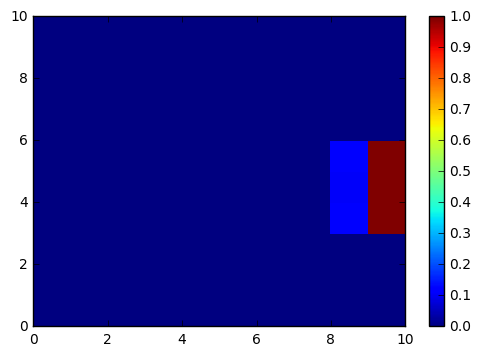

In [34]:

plt.pcolormesh(h[40:50, 55:])
plt.colorbar()


In [35]:
def output():
    # Write to file 'restart.out'.
    file = open("restart_py.out", "w")
    file.write( "j, k, h[j, k], u[j, k], v[j, k], t0[j,k] \n")
    for j in range(1, ncol+1):
        for k in range(kbeg[j], kend[j]+1):
            file.write("%i   %i   %.3f   %.3f   %.3f   %.3f\n"%(
                    j, k, h[j, k], u[j, k], v[j, k], t0[j,k]))            
    #  Push cell-centered values to corner nodes for plotting.
    interp(h, u, v)
    iout = float(raw_input("enter output option: "))
    if iout == 1:
        file.write('VARIABLES = "X", "Y", "H", "U", "V", "Z", "Fr"\n')   
        #file.write('ZONE N=',npt,' E=',ne,' F=FEPOINT', ' ET=QUADRILATERAL')
        file.write('ZONE N={0}, E={1}, F=FEPOINT,  ET=QUADRILATERAL\n'.format(npt, ne))
        for n in range(1, npt+1):
            if hn[n]> 0.:
                fr = np.sqrt(un[n]*un[n] + vn[n]*vn[n])/(grav*hn[n])
            else: 
                fr = 0.
            file.write('{0}, {1}, {2}, {3}, {4}, {5}, {6}\n'.format(
                    x[n],y[n],hn[n],un[n],vn[n],z[n],fr))
    elif iout == 2:
        file.write('VARIABLES = "X", "Y", "Z", "U", "V", "H", "Fr"\n')
        file.write('ZONE N={0}, E={1}, F=FEPOINT, ET=QUADRILATERAL\n'.format(
                npt, ne))
        for n in range(1, npt+1):
            if hn[n] > 0.:
                fr = np.sqrt((un[n]*un[n] + vn[n]*vn[n])/(grav*hn[n]))
            else:
                fr = 0.
            file.write('{0}, {1}, {2}, {3}, {4}, {5}, {6}\n'.format(
                    x[n],y[n],z[n],un[n],vn[n],hn[n],fr))
    elif iout == 3:
        file.write('VARIABLES = "X", "Y", "H+Z", "U", "V", "H", "Z", "Fr"\n')
        file.write('ZONE N={0}, E={1}, F=FEPOINT,  ET=QUADRILATERAL\n'.format(
                npt, ne))
        for n in range(1, npt+1): 
            if hn[n]> 0.:
                fr = np.sqrt((un[n]*un[n] + vn[n]*vn[n])/(grav*hn[n]))
            else:
                fr = 0.
            file.write('{0}, {1}, {2}, {3}, {4}, {5}, {6}\n'.format(
                x[n],y[n],hn[n]+ z[n], un[n], vn[n], hn[n], z[n], fr))
    for j in range(1, ncol+1):  
        for k in range(kbeg[j],kend[j]+1):
            file.write('{0}, {1}, {2}, {3}\n'.format(nop[j,k,0], nop[j,k,1], nop[j,k,2], nop[j,k,3]))
    file.close()
    

In [ ]:
output()


In [ ]:
ipos2 = np.zeros([ncol+1, nrow+1, 2])
ipos2[1, 1:, 0] = 4.
ipos2[-1, 1:-1, 0] = 2.
ipos2[2:, -1, 0] = 3
ipos2[2:-1,1, 0] = 1

In [ ]:
inum

In [ ]:
plt.figure()
plt.pcolor(itype[:, :, 0] , cmap= 'rainbow')
plt.colorbar()

In [ ]:
# for j in range(1, ncol+1):
#     print j, kbeg[j], kend[j]